## Build a Toy Chatbot Using Sequence-to-Sequence Model

The dataset is downloaded from https://www.kaggle.com/eibriel/rdany-conversations. 

In [172]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import tensorflow as tf
import numpy as np
import unicodedata
import re
import pandas as pd
import keras
from keras.models import Model
from keras.preprocessing import text
from keras.layers import Input, LSTM, Dense, Embedding
from keras.utils.np_utils import to_categorical
from sklearn.utils import shuffle

In [173]:
import pandas as pd
from sklearn.utils import shuffle

raw_data = pd.read_csv("chatbot.csv")
print(raw_data)


                                               question                                             answer
0                                                    hi                               hi there how are you
1     oh thanks i m fine this is an evening in my ti...                                  here is afternoon
2     how do you feel today tell me something about ...  my name is rdany but you can call me dany the ...
3                 how many virtual friends have you got  i have many but not enough to fully understand...
4     is that forbidden for you to tell the exact nu...  i ve talked with 143 users counting 7294 lines...
...                                                 ...                                                ...
2358                                               hi f                                hi here how are you
2359                                               good                                  nice i m fine too
2360                                 

In [174]:
# Split the dataset and reserve 20 for testing

raw_data = shuffle(raw_data)

# reserver 20 for testing
test = raw_data.iloc[0:20]
conv = raw_data.iloc[20:]

len(conv)
len(test)

2343

20

### Task (1) Data Preprocessing
In the model, the `question (Q)` text should be treated as the `input` to the encoder model, and the `answer (A)` text should be used as both the input and the ground-truth target of the decode model. Here we'll create a `teacher forcing` model. Specifically, we need to make decisions on the following:
- The number of words in your vocabulary. 
- The sentence lengths `max_lefor `Q` and `A`
- <font color='blue'> Different from the translation model, here both `Q` and `A` are in the same language. we only need one tokenizer. </font>
- The output of this task is training and testing dataset, specifically:
    - `data_q`: Encoder input (`Q`) sequences for training
    - `data_a_in`: Decoder input (`A`) sequences for training
    - `data_a_out`: Decoder output (`A`) sequences for calculating loss during training. One hot encoding is needed if you use categorical cross entropy cost
    - `data_test`: Encoder input (`Q`) sequences for testing


In [175]:
conv["answer"] = conv["answer"].astype(str)
raw_a_in = ['<start> ' + data for data in conv["answer"]]
raw_a_out = [ data + ' <end>' for data in conv["answer"]]

raw_data_q = conv["question"]
raw_data_q = raw_data_q.astype(str)

raw_test_q = test["question"]
raw_test_q = raw_test_q.astype(str)
print(raw_a_in)


['<start> yes i m learning all the time', '<start> full of energy', '<start> i m from argentina south of the world xd', '<start> i m fine nice to meet you', '<start> nada leí algo en internet y vos', '<start> is late there', '<start> i only made this computer work it was disassembled and hacked a bit to be able to access internet and chat here', '<start> i do lot of things i chat with people learn things and you', '<start> excelente a tan sólo 1500km', '<start> hi how are you', '<start> i can t do that sorry take time to process answers to robots i m not fast as a human', '<start> nama saya dany', '<start> i just can write simple music by my own using neural networks probably recurrent neural networks are good for that', '<start> do you like music', '<start> hi there how are you today', '<start> nan', '<start> nice feel free to talk to me any time', '<start> hi there how are you', '<start> learning languages is hard yes', '<start> that is right nice to meet you askar', '<start> you re 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([6. , 6.2, 6.4, 6.6, 6.8, 7. , 7.2, 7.4, 7.6, 7.8, 8. ]),
 <a list of 10 Patch objects>)

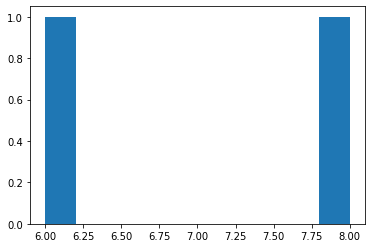

In [178]:
from matplotlib import pyplot as plt
plt.hist([len(question) for question in raw_data])
plt.show()

(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([6. , 6.2, 6.4, 6.6, 6.8, 7. , 7.2, 7.4, 7.6, 7.8, 8. ]),
 <a list of 10 Patch objects>)

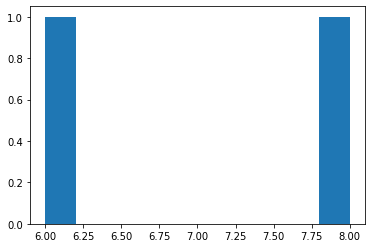

In [179]:
from matplotlib import pyplot as plt
plt.hist([len(answer) for answer in raw_data])
plt.show()


Therefore, the sentence lengths max_le for Q = 10, the sentence lengths max_len for A = 10. I decide max_len=10


In [180]:
max_words = 5000
max_len = 10
en_tokenizer = keras.preprocessing.text.Tokenizer(filters='', \
                                                  num_words=max_words )
en_tokenizer.fit_on_texts(raw_a_in)
en_tokenizer.fit_on_texts(raw_a_out)
en_tokenizer.fit_on_texts(raw_data_q)
en_tokenizer.fit_on_texts(raw_test_q)

In [181]:
data_q = en_tokenizer.texts_to_sequences(raw_data_q)
data_q = keras.preprocessing.sequence.pad_sequences(data_q,\
                                                     maxlen=max_len, \
                                                     padding='post')
# print a sample sentence after preprocessing
print(data_q[:3])

[[  14    2  131   20    5 1797    0    0    0    0]
 [ 118   39   20   14    2  144   52    0    0    0]
 [ 162    9    2 3336    0    0    0    0    0    0]]


In [182]:

data_a_in = en_tokenizer.texts_to_sequences(raw_a_in)
data_a_in = keras.preprocessing.sequence.pad_sequences(data_a_in,\
                                                     maxlen=max_len, \
                                                     padding='post')

data_a_out = en_tokenizer.texts_to_sequences(raw_a_out)
data_a_out = keras.preprocessing.sequence.pad_sequences(data_a_out,\
                                                     maxlen=max_len, \
                                                     padding='post')

data_test = en_tokenizer.texts_to_sequences(raw_test_q)
data_test = keras.preprocessing.sequence.pad_sequences(data_test,\
                                                     maxlen=max_len, \
                                                     padding='post')

# print a sample sentence after preprocessing
print(data_test[:3])

[[ 426   39  143    1   40    0    0    0    0    0]
 [   9 1194 1209   56  249    8  318  562   36  471]
 [ 181   16  944  181   16  944    8  335  647    0]]


In [183]:
# Create the reversal mapping between indexes and words
reverse_en_word_index ={en_tokenizer.word_index[w] : w \
                        for w in  en_tokenizer.word_index}


In [184]:
print("index of symbol <start> :", en_tokenizer.word_index["<start>"])
print("index of symbol <end> :", en_tokenizer.word_index["<end>"])

index of symbol <start> : 3
index of symbol <end> : 4


In [185]:
# Convert each word index using one-hot coding
# This variable is the target of training

data_a_out_cat = to_categorical(data_a_out, num_classes=max_words)
data_a_out_cat.shape

# check one sample
data_a_out_cat[0,0,0:100]

(2343, 10, 5000)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

### Task (2) Define "Teacher Forcing" Model 
- You can reference to Lab_3_NTM to create the model for training process and also an inference model for the testing process
- Tune the hyperparameters, e.g. the embeding dimension, units for LSTM layers, dropout, epoches, batch size etc.
- Train the model with 20% of the samples for validation. Plot training and validation loss/accuracy
- Call the inference model with the test samples to check if the generated answers make sense.

Important:
- To reduce the number of parameters, you can use `a shared embedding layer` for both encoder and decoder. The words in `Q` and `A` are in the same language and they can be converted into word vectors by the same embedding layer

- Since each sentence is very short and "0" padding is used to get uniform length. we use `masking` to denote no more processing after "0" is hit. The simplest way to enable masking is to set `mask_zero = True` in the embedding layer.

Analysis:

--According to last step, I decide the max_en_words = 5000, max_en_len = 10, lstm size = 100

--The performance is not good. To imporve it, maybe should add other layer to extrac more information like bi-lstm

In [186]:

max_en_words = 5000
max_en_len = 10
latent_dim = 100 

encoder_inputs = Input(shape=(max_en_len,), name="data_q")
decoder_inputs = Input(shape=(max_en_len,), name="data_a_in")

embedding_layer = Embedding(max_en_words, latent_dim, \
                          input_length=max_en_len, mask_zero=True)

encoder_inputs_encoded = embedding_layer(encoder_inputs)
decoder_inputs_encoded = embedding_layer(decoder_inputs)

encoder_lstm = LSTM(latent_dim,return_state=True,\
                   dropout=0.2, recurrent_dropout=0.2, name='encoder')
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs_encoded)
encoder_states = [state_h, state_c]



In [187]:
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,\
                   dropout=0.2, recurrent_dropout=0.2,name='decoder')
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_encoded, initial_state=encoder_states)
decoder_dense = Dense(max_en_words, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [188]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "functional_106"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data_a_in (InputLayer)          [(None, 10)]         0                                            
__________________________________________________________________________________________________
data_q (InputLayer)             [(None, 10)]         0                                            
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 10, 100)      500000      data_q[0][0]                     
                                                                 data_a_in[0][0]                  
__________________________________________________________________________________________________
encoder (LSTM)                  [(None, 100), (None, 80400       embedding_13[0][0]  

- `encoder_inputs` <-> `data_q`
- `decoder_inputs` <-> `data_a_in`
- `decoder_outputs` <-> `data_a_out`

In [189]:
# Train your mode
batch_size=32
epochs = 20


# Compile & run training
model.compile(optimizer='rmsprop', \
              loss='categorical_crossentropy',\
              metrics=['categorical_accuracy'])

history = model.fit([data_q, data_a_in],data_a_out_cat, batch_size=batch_size,\
                       verbose =2, epochs=epochs, \
                       validation_split=0.2)

Epoch 1/20
59/59 - 8s - loss: 4.5473 - categorical_accuracy: 0.1405 - val_loss: 4.1041 - val_categorical_accuracy: 0.1436
Epoch 2/20
59/59 - 8s - loss: 3.9516 - categorical_accuracy: 0.1498 - val_loss: 4.0464 - val_categorical_accuracy: 0.1543
Epoch 3/20
59/59 - 8s - loss: 3.8421 - categorical_accuracy: 0.1558 - val_loss: 4.0264 - val_categorical_accuracy: 0.1552
Epoch 4/20
59/59 - 8s - loss: 3.7541 - categorical_accuracy: 0.1587 - val_loss: 4.0104 - val_categorical_accuracy: 0.1513
Epoch 5/20
59/59 - 8s - loss: 3.6746 - categorical_accuracy: 0.1599 - val_loss: 3.9992 - val_categorical_accuracy: 0.1586
Epoch 6/20
59/59 - 8s - loss: 3.5958 - categorical_accuracy: 0.1678 - val_loss: 3.9298 - val_categorical_accuracy: 0.1684
Epoch 7/20
59/59 - 8s - loss: 3.5098 - categorical_accuracy: 0.1778 - val_loss: 3.8905 - val_categorical_accuracy: 0.1773
Epoch 8/20
59/59 - 8s - loss: 3.4288 - categorical_accuracy: 0.1897 - val_loss: 3.8443 - val_categorical_accuracy: 0.1880
Epoch 9/20
59/59 - 8s - 

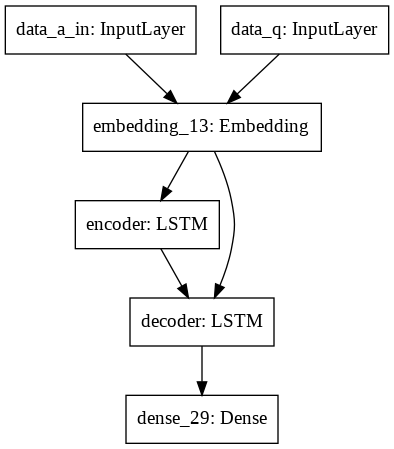

In [190]:

from IPython.display import Image
from keras.utils.vis_utils import model_to_dot

G = model_to_dot(model)
Image(G.create(prog="dot", format="png"))

Text(0.5, 1.0, 'Training and validation loss')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

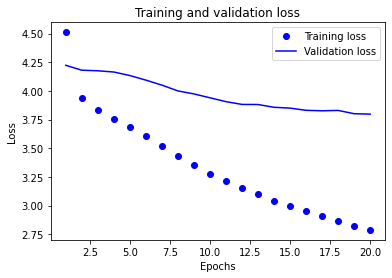

Text(0.5, 1.0, 'Training and validation accuracy')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

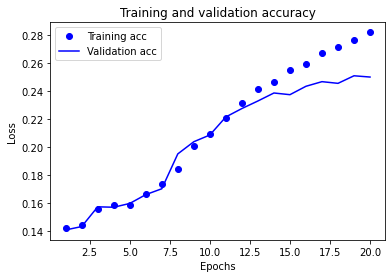

In [91]:
# Training process plot 
import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [193]:
# Define Inference Model
# encoder and decoder models in inference

encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,), name="encoder_h")
decoder_state_input_c = Input(shape=(latent_dim,), name='encoder_c')
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_embed = embedding_layer(decoder_inputs)
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_embed, initial_state=decoder_states_inputs)

decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [93]:
# Define function to generate sentence
def decode_sequence(input_seq):  # input_seq is a English sentence
    
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1. (i.e. we translate word by word)
    target_seq = np.zeros((1, 1))
    
    # Populate the start symbol of target sequence with the start character.
    target_seq[0, 0] = en_tokenizer.word_index["<start>"]
    
    # Generate word by word using the encode state and the last 
    # generated word
    
    decoded_sentence = []
   
    while True:
        
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Get the most likely word
        sampled_token_index = np.argmax(output_tokens[0, 0,:])
        
        # Look up the word by id
        sampled_word = reverse_en_word_index[sampled_token_index]
        
        decoded_sentence.append(sampled_word)

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_word == '<end>' or len(decoded_sentence) == max_en_len):
            break

        # Update the target sequence with newly generated word.
        target_seq[0,0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return ' '.join(decoded_sentence)


In [192]:
# Test the first 20 sentences

for i in range(len(data_test)):
    a = decode_sequence(data_test[i][None,:])  # generate sentences
    print("\nQuestion: ", test.iloc[i]["question"])
    print("Answer: ", test.iloc[i]["answer"])
    print("Generated: ", a)


Question:  hahahaha so am i your experiment
Answer:  yes but in the good way haha
Generated:  i m fine to have <end>

Question:  hahaha don t worry some of them are completely basic just ask the their opinion on justin beiber
Answer:  nan
Generated:  i like a a a moment <end>

Question:  send me uzbek send me uzbek ar the moment fast
Answer:  elektr pastga hajmi skrinshot qilish
Generated:  i m a a the same <end>

Question:  any words or tips for move on dany
Answer:  i m not fully understand human emotions so i ll say seek advice on a human who you can trust
Generated:  nan <end>

Question:  muchísimo tú me recomendarías una peli de ciencia ficción chula tienes novia
Answer:  has visto chappie jaja no ese tipo de relación es muy compleja para mi
Generated:  que que que que que de de en <end>

Question:  es muy optimista eso me fascina
Answer:  si tu eres optimista también
Generated:  nan <end>

Question:  soy muy sola
Answer:  yo puedo hacerte compañía
Generated:  nan <end>

Question

### Task (3): Improve the model

With the baseline performance obtained by Task (2), consider the following ways to improve the performance:
- Use `Bidirectional LSTM` in the encoder model. Note, 
    - Output dimension and state dimensions will be doubled. This change will impact subsquent layers.
    - The states from backward and forward LSTM should be concatenated and then used in the initialization of decoder LSTM

- Add an attention mechanism.

- Modify the inference model accordingly and check how the model performs during testing

- Plot the validation loss and accuracy of the improved model and compare it with the result in Task (2)



**Based on your results, describe why (why not) these change improve the text generation**
-- I think Bi-LSTM extrack more infromation from tests than baseline model. And, adding attention mechinism help model focus on "important infromation" not "all information". It is imporve the model performance. But in this case, because of the small dataset, the performance will be worse if using a complicated model
**Please share us with your experience here, e.g. what have you learned through this assignment and what part can be difficult to implement.**
-- From this work, I know the inner structure of encoder and decoder, and know how to use Bi-Lstm and attention mechinism. The difficult one is we need to focus on the shape of tensor all the time, in order to keep the model layer can connect.

In [206]:
# Modify the model 
from tensorflow.keras import layers
encoder_inputs = Input(shape=(max_en_len,), name="data_q")
decoder_inputs = Input(shape=(max_en_len,), name="data_a_in")


emberdding_layer = Embedding(max_en_words, latent_dim, \
                          input_length=max_en_len, mask_zero=True)

encoder_inputs_encoded = embedding_layer(encoder_inputs)
decoder_inputs_encoded = embedding_layer(decoder_inputs)

encoder_lstm = layers.Bidirectional(LSTM(latent_dim,return_sequences=True,return_state=True,\
                   dropout=0.2, recurrent_dropout=0.2))

encoder_outputs, forward_h, forward_c, backward_h, backward_c= encoder_lstm(encoder_inputs_encoded)
encoder_states = [forward_h, forward_c, backward_h, backward_c]



In [207]:
states_h = tf.concat([forward_h,backward_h],1)
states_c = tf.concat([forward_c,backward_c],1)

encoder_states_concat = [states_h,states_c]

In [208]:
decoder_lstm = LSTM(200, return_sequences=True, return_state=True,\
                   dropout=0.2, recurrent_dropout=0.2)

decoder_outputs, _, _= decoder_lstm(decoder_inputs_encoded, initial_state=encoder_states_concat)

decoder_dense = Dense(max_en_words, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)


In [209]:
from keras.layers import Lambda, Dot, Activation, Concatenate, Dropout
from keras import backend as K

# Transform encoder outputs to a space which can be aligned with decoder output
encoder_outputs_transformed = Dense(latent_dim, \
                                    activation=None, \
                                    use_bias=False)(encoder_outputs)
encoder_outputs_transformed.shape

TensorShape([None, 10, 100])

In [210]:


# Calculate alignment between decoder and encoder
attention = Dot(axes = [2,2])([decoder_inputs_encoded, encoder_outputs_transformed])
attention = Activation('tanh')(attention)

# Normalize alignment score
attention = Activation('softmax')(attention)

# Weighted sum
context = Dot(axes=[2,1]) ([attention, encoder_outputs])

# Concatenate context with decoder output
decoder_combined_context = Concatenate(axis = -1)([context, decoder_outputs])

decoder_dense = Dense(max_en_words, activation='softmax')
decoder_outputs = decoder_dense(decoder_combined_context)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`


In [211]:
model_new=None
model_new = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model_new.summary()



Model: "functional_123"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data_a_in (InputLayer)          [(None, 10)]         0                                            
__________________________________________________________________________________________________
data_q (InputLayer)             [(None, 10)]         0                                            
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 10, 100)      500000      data_q[0][0]                     
                                                                 data_a_in[0][0]                  
__________________________________________________________________________________________________
bidirectional_8 (Bidirectional) [(None, 10, 200), (N 160800      embedding_13[6][0]  

In [212]:
batch_size=32
epochs = 20

# Compile & run training
model_new.compile(optimizer='rmsprop', \
              loss='categorical_crossentropy',\
              metrics=['categorical_accuracy'])

hist2 = model_new.fit([data_q, data_a_in],data_a_out_cat, batch_size=batch_size,\
                       verbose =2, epochs=epochs, \
                       validation_split=0.2)

Epoch 1/20
59/59 - 85s - loss: 4.8684 - categorical_accuracy: 0.1365 - val_loss: 4.5490 - val_categorical_accuracy: 0.1439
Epoch 2/20
59/59 - 84s - loss: 4.2490 - categorical_accuracy: 0.1409 - val_loss: 4.4093 - val_categorical_accuracy: 0.1427
Epoch 3/20
59/59 - 84s - loss: 4.0667 - categorical_accuracy: 0.1416 - val_loss: 4.3373 - val_categorical_accuracy: 0.1427
Epoch 4/20
59/59 - 85s - loss: 3.9349 - categorical_accuracy: 0.1425 - val_loss: 4.2791 - val_categorical_accuracy: 0.1436
Epoch 5/20
59/59 - 85s - loss: 3.8380 - categorical_accuracy: 0.1431 - val_loss: 4.2347 - val_categorical_accuracy: 0.1433
Epoch 6/20
59/59 - 85s - loss: 3.7651 - categorical_accuracy: 0.1444 - val_loss: 4.2159 - val_categorical_accuracy: 0.1442
Epoch 7/20
59/59 - 85s - loss: 3.7047 - categorical_accuracy: 0.1452 - val_loss: 4.1927 - val_categorical_accuracy: 0.1442
Epoch 8/20
59/59 - 85s - loss: 3.6454 - categorical_accuracy: 0.1497 - val_loss: 4.1675 - val_categorical_accuracy: 0.1497
Epoch 9/20
59/59

In [200]:
# Redefine the model for inference stage
# encoder and decoder models in inference

encoder_model = Model(encoder_inputs, encoder_states_concat)

decoder_state_input_h = Input(shape=(200,), name="encoder_h")
decoder_state_input_c = Input(shape=(200,), name='encoder_c')
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_embed = emberdding_layer(decoder_inputs)
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_embed, initial_state=decoder_states_inputs)

decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [144]:
# Define function to generate sentence
def decode_sequence(input_seq):  # input_seq is a English sentence
    
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1. (i.e. we translate word by word)
    target_seq = np.zeros((1, 1))
    
    # Populate the start symbol of target sequence with the start character.
    target_seq[0, 0] = en_tokenizer.word_index["<start>"]
    
    # Generate word by word using the encode state and the last 
    # generated word
    
    decoded_sentence = []
   
    while True:
        
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Get the most likely word
        sampled_token_index = np.argmax(output_tokens[0, 0,:])
        
        # Look up the word by id
        sampled_word = reverse_en_word_index[sampled_token_index]
        
        decoded_sentence.append(sampled_word)

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_word == '<end>' or len(decoded_sentence) == max_en_len):
            break

        # Update the target sequence with newly generated word.
        target_seq[0,0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return ' '.join(decoded_sentence)


In [171]:
# Test 

for i in range(len(data_test)):
    a = decode_sequence(data_test[i][None,:],attention = True)
    print("\nQuestion: ", test.iloc[i]["question"],attention=True)
    print("Answer: ", test.iloc[i]["answer"])
    print("Generated: ", a)


Question:  aaahh i m okay
Answer:  nan
Generated:  entender cc cc staff become logro peligrosos scare logro blackmirror

Question:  i like twilight sparkle well can you produce a cartoon
Answer:  anime that would be nice do you draw
Generated:  cover cc 1st hahhahah receiving serials serials late score olvide

Question:  how are you good thank you who are you
Answer:  i m rdany a robot we can be friends
Generated:  berishim reply fifth discovering experiment emulate 443 internal https ficciòn

Question:  todo se andará o se escuchara hasta tú lo lograras tocas raro hice bien en no escuchar antes
Answer:  seguiré practicando
Generated:  debian 60 60 orange donate sip sip roboticista conecto analyse

Question:  alright then if you like you can help me out with an important decision i can either watch an episode of king of the hill or go to sleep what shall i do
Answer:  i can t tell you what to do but king of the hill sounds like a great plan
Generated:  honest super rato christianity c

Text(0.5, 1.0, 'Validation loss')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

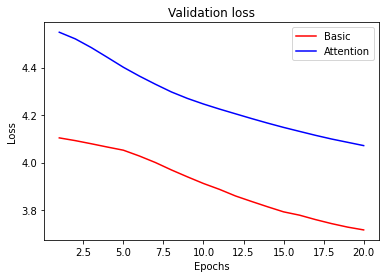

Text(0.5, 1.0, 'Validation Accuracy')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Accuracy')

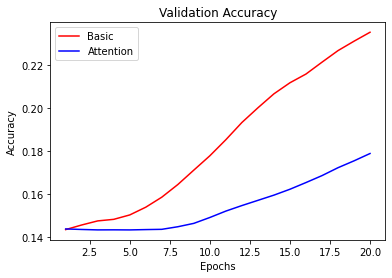

In [218]:
# Compare the result

def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

epochs = range(1, len(history.history['val_loss']) + 1)
plt.plot(epochs, smooth_curve(history.history['val_loss']), 'r-', label='Basic')
plt.plot(epochs, smooth_curve(hist2.history['val_loss']), 'b-', label='Attention')
plt.title('Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

epochs = range(1, len(history.history['val_categorical_accuracy']) + 1)
plt.plot(epochs, smooth_curve(history.history['val_categorical_accuracy']), 'r-', label='Basic')
plt.plot(epochs, smooth_curve(hist2.history['val_categorical_accuracy']), 'b-', label='Attention')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()